# Feature engineering on Thoth Station Github PR Data

In this notebook, we look at feature importances on PR data extracted from thoth-station organization.

In [1]:
import os
import ast
from io import StringIO
import sys
import pathlib
from tqdm import tqdm
from functools import partial
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, f_classif

from dotenv import load_dotenv, find_dotenv

metric_template_path = "../../data-sources/TestGrid/metrics"
if metric_template_path not in sys.path:
    sys.path.insert(1, metric_template_path)

from ipynb.fs.defs.metric_template import (  # noqa: E402
    CephCommunication,
    save_to_disk,
)

In [2]:
sns.set(rc={"figure.figsize": (20, 10)})
load_dotenv(find_dotenv())

True

In [3]:
## CEPH Bucket variables
## Create a .env file on your local with the correct configs,
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY", "github")
s3_input_data_path = "raw_data"
REMOTE = os.getenv("REMOTE")

In [4]:
# data_path = "thoth_PR_data.csv"
OUTPUT_DATA_PATH = "output"

if REMOTE:
    print("getting dataset from ceph")
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    s3_object = cc.s3_resource.Object(s3_bucket, "thoth_PR_data.csv")
    file = s3_object.get()["Body"].read().decode("utf-8")

pr_df = pd.read_csv(StringIO(file))

getting dataset from ceph


In [5]:
pr_df.shape

(22340, 24)

In [6]:
pr_df.head(2)

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,org,repo,index
0,0,0,678.0,Automatic update of base-image in CI,Automatic update of base-image in CI.,XS,sesheta,2022-05-09 19:38:22,2022-05-09 19:43:18,harshad16,...,{'sesheta': 210},"{'966742282': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/XS', 'ok-to-test']",['1a643bbdf0304b1d7b94e374680901765bb695c1'],['.aicoe-ci.yaml'],2022-05-09 19:38:24,2022-05-09 19:38:24,thoth-station,graph-refresh-job,NaN
1,1,1,677.0,Release of version 0.3.19,"Hey, @harshad16!\n\nOpening this PR to fix the...",XS,khebhut[bot],2022-05-09 19:36:51,2022-05-09 19:43:05,harshad16,...,{'sesheta': 252},"{'966740804': {'author': 'sefkhet-abwy[bot]', ...","['approved', 'size/XS', 'bot', 'needs-ok-to-te...",['050ed88f0b7b0dcaa94ea082d5a1a34862d59848'],"['CHANGELOG.md', 'version.py']",2022-05-09 19:36:53,2022-05-09 19:36:53,thoth-station,graph-refresh-job,NaN


## Inspect the dataset

Let's unroll a single row and see what kind of information we have access to. 

In [7]:
pr = pr_df.iloc[4]
pr

Unnamed: 0.1                                                            4
Unnamed: 0                                                              4
id                                                                  672.0
title                   Automatic update of dependencies by Kebechet f...
body                    Kebechet has updated the dependencies to the l...
size                                                                    L
created_by                                                   khebhut[bot]
created_at                                            2022-02-24 17:42:22
closed_at                                             2022-02-24 18:11:28
closed_by                                                         sesheta
merged_at                                             2022-02-24 18:11:28
merged_by                                                         sesheta
commits_number                                                        1.0
changed_files_number                  

## Remove PRs created by Bots

As a part of our training dataset, we do not want to include PRs that are created by bots. So lets remove them first.

In [8]:
set(pr_df["created_by"])

{'4n4nd',
 'CermakM',
 'EldritchJS',
 'GiorgosKarantonis',
 'Gkrumbach07',
 'Gregory-Pereira',
 'HumairAK',
 'KPostOffice',
 'MichaelClifford',
 'Misoslav',
 'RonnanSouza',
 'Shreyanand',
 'Xaenalt',
 'abompard',
 'ace2107',
 'anishasthana',
 'bissenbay',
 'bjoernh2000',
 'chashtag',
 'codacy-badger',
 'codificat',
 'ddehueck',
 'dependabot-preview[bot]',
 'dependabot[bot]',
 'dependencies[bot]',
 'depouill',
 'durandom',
 'erikerlandson',
 'flowersw',
 'frenzymadness',
 'fridex',
 'github-actions[bot]',
 'goern',
 'guimou',
 'harshad16',
 'hemajv',
 'hroncok',
 'hugovk',
 'jhutchings1',
 'jrottenberg',
 'khebhut[bot]',
 'larsks',
 'leonjia0112',
 'matt-carr',
 'mayaCostantini',
 'meile18',
 'mimotej',
 'oindrillac',
 'pacospace',
 'pdmack',
 'peremoar',
 'quaid',
 'ram-nad',
 'saisankargochhayat',
 'schwesig',
 'sesheta',
 'shreekarSS',
 'shruthi-raghuraman',
 'srushtikotak',
 'sub-mod',
 'sushmithaaredhatdev',
 'tlegen-k',
 'tmckayus',
 'tumido',
 'tushar7sharma',
 'vpavlin',
 'werne

Let's remove PRs that are created by 'sesheta', 'khebhut[bot]', 'dependabot-preview[bot]', 'dependabot[bot]', 'dependencies[bot]', 'github-actions[bot]', 'codacy-badger'

In [9]:
bots = [
    "sesheta",
    "khebhut[bot]",
    "dependabot-preview[bot]",
    "dependabot[bot]",
    "dependencies[bot]",
    "github-actions[bot]",
    "codacy-badger",
]

In [10]:
pr_df = pr_df[~pr_df["created_by"].isin(bots)]

In [11]:
pr_df.shape

(10967, 24)

</br>

#### **Available Fields**

* **title**: text providing a short description of the of the PR.

* **body**: text providing additional details regarding the changes. 

* **size**: categorical label generated by GitHub summerizing the size of the changes made to the code base. 

* **created/closed/merged_at**: timestamps for when the PR was opened, merged and finally closed. 

* **created/closed_by**: usernames for contributors who created the PR and closed it. 

* **commits_number**: integer indicating the number of commits in the PR.

* **changed_files_number**: integer indicating the number of files changed.

The remaining fields appear to be collections of items, let's unroll each one and see what additional information they provide.


In [12]:
pr["interactions"]

"{'sesheta': 257}"

**interactions**: a dictionary with usernames for keys and the number of words commented on the PR by the user

In [13]:
pr["reviews"]

"{'892779373': {'author': 'sefkhet-abwy[bot]', 'words_count': 7, 'submitted_at': 1645724545, 'state': 'APPROVED'}}"

**reviews**: a dictionary of reviews that includes an id number key along with fields for author, word_count, submitted timestamp and state of review.

In [14]:
pr["labels"]

"['approved', 'size/L', 'bot', 'needs-ok-to-test', 'ok-to-test']"

**labels**: a list of labels tagged to the PR describing some of its attributes

In [15]:
pr["commits"]

"['d06965a0ab7c603b9adb8dbc747b47e963209a8f']"

**commits**: a list of commit hashes that point to specific changes made to the repo's history

In [16]:
print(len(pr["changed_files"]))
pr["changed_files"][0:16]

16


"['Pipfile.lock']"

**changed_files**: a list of the paths and filenames for every file changed by this PR.

We now know what we have access to in this dataset. It is a collection of numerical, categorical and textual features used to describe a PR. This gives us a lot of potential avenues to explore from an EDA and Data Science perspective. But is also creates an additional challenge insofar as we'll need to do a bit of feature engineering to get this data into format that is ready to be ingested by any ML models. 

## Feature engineering

In the next section we will do some basic feature engineering and correlation analyis on our dataset to see if anything interesting jumps out at us. 

**Time to Merge**

We will derive a new feature called `time_to_merge` which will be the difference between the `created_at` and `merged_at` fields. 

In [17]:
# derive time_to_merege
pr_df["time_to_merge"] = pd.to_datetime(pr_df["merged_at"]) - pd.to_datetime(
    pr_df["created_at"]
)

In [18]:
pr_df["time_to_merge"] = pr_df["time_to_merge"] / np.timedelta64(1, "s")

In [20]:
# NOTE: we cant fill NA with 0 because that would imply the PR got merged instantaneously

Let's look at the distribution of the time to merge column. This can help us determine what the setup for ML problems such as [#236](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/236) could be like. That is, should the time to merge problem be framed as a regression or classification problem.

First, lets try to determine what the granularity of the output values should be, in case of a regression setup. That is, should the model predict time to merge in number of seconds, number of hours, number of days, or some other chunk of time.

In [21]:
# what does the distribution of values look like if we choose days as the granularity
ttm_days = np.ceil(pr_df.time_to_merge / (60 * 60 * 24))

# value counts - to how many PRs have value 1, 2, 3, etc. for days to merge
vc = ttm_days.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0        0.787047
2.0        0.044427
3.0        0.029420
4.0        0.022115
5.0        0.017080
             ...   
18251.0    0.000099
18259.0    0.000099
18273.0    0.000099
18281.0    0.000099
345.0      0.000099
Name: time_to_merge, Length: 152, dtype: float64

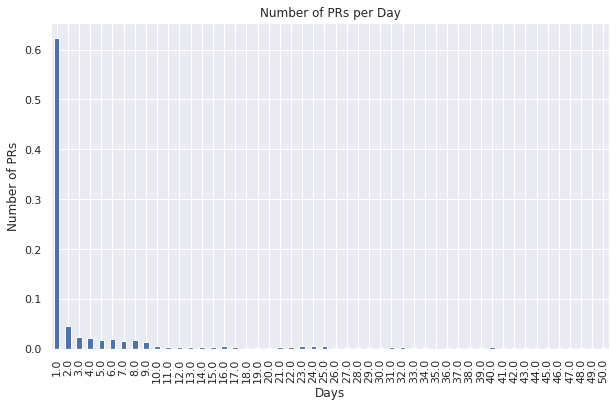

In [24]:
# only plot top 50 values so that graph is legible
plt.rcParams["figure.figsize"] = (10, 6)
nvc.sort_index().iloc[:50].plot(kind="bar")
plt.xlabel("Days")
plt.ylabel("Number of PRs")
plt.title("Number of PRs per Day")
plt.show()

From the above graph we can see that if we bucket the data into days, then roughly 80% of the data points would have the value "1", 5% would have the value "2" and so on. Therefore we need to select a finer granularity. 

In [25]:
# what if we chose some intermediate value e.g. 3 hours as the granularity?
ttm_3hours = np.ceil(pr_df.time_to_merge / (60 * 60 * 3))

# value counts - to how many PRs have value 1, 2, 3, etc. for num. 3-hours to merge
vc = ttm_3hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0         0.622470
2.0         0.045019
3.0         0.024484
4.0         0.022510
6.0         0.019449
              ...   
146066.0    0.000099
146005.0    0.000099
146074.0    0.000099
145750.0    0.000099
233.0       0.000099
Name: time_to_merge, Length: 407, dtype: float64

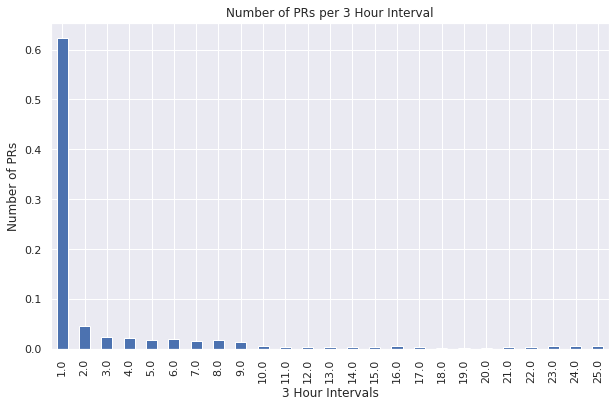

In [26]:
# only plot top 25 values so that graph is legible
nvc.sort_index().iloc[:25].plot(kind="bar")
plt.xlabel("3 Hour Intervals")
plt.ylabel("Number of PRs")
plt.title("Number of PRs per 3 Hour Interval")
plt.show()

From the above outputs we can see that if we bucket the data into 3 hours, then roughly 65% of the data points would have the value "1", 5% would have the value "2", 3% would have the value 3, and so on. Lets explore what this would look like with an "hours" granularity.

In [27]:
# what if we chose hours as the granularity?
ttm_hours = np.ceil(pr_df.time_to_merge / (60 * 60))

# value counts - to how many PRs have value 1, 2, 3, etc. for hours to merge
vc = ttm_hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0       0.534604
2.0       0.055780
3.0       0.032086
4.0       0.020041
5.0       0.014315
            ...   
1407.0    0.000099
253.0     0.000099
278.0     0.000099
900.0     0.000099
1174.0    0.000099
Name: time_to_merge, Length: 661, dtype: float64

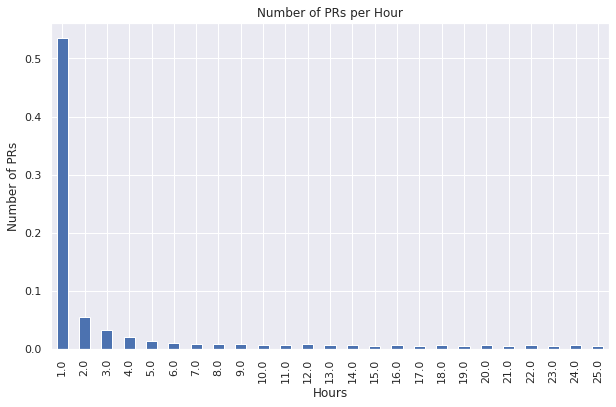

In [28]:
# only plot top 25 values so that graph is legible
nvc.sort_index().iloc[:25].plot(kind="bar")
plt.xlabel("Hours")
plt.ylabel("Number of PRs")
plt.title("Number of PRs per Hour")
plt.show()

From the above outputs we can see that if we bucket the data into hours, then roughly 55% of the data points would have the value "1", 5% would have the value "2", 3% would have the value 3, and so on. 

As we make it more granular (e.g. minutes), the distribution would get even more uniform. However, a granularity finer than 1 hour might not provide any additional value to the end user. So we will go with granularity of 1 hour for our regression setup.

Now, lets try to determine, if we were to set this up as a classification problem, what the output classes should be. In the following cell, we'll try to split the time-to-merge values into 10 equally populated buckets.

In [29]:
pr_df.head(10)

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,reviews,labels,commits,changed_files,first_review_at,first_approve_at,org,repo,index,time_to_merge
6,6,6,668.0,set badges for easy access to content,set badges for easy access to content\r\nSigne...,S,harshad16,2022-02-01 00:00:46,2022-02-01 07:07:54,sesheta,...,"{'868731801': {'author': 'fridex', 'words_coun...","['approved', 'size/S']",['01364aad0093bb29fdb96332568e95f798150e61'],['README.rst'],2022-02-01 07:05:14,2022-02-01 07:05:14,thoth-station,graph-refresh-job,NaN,25628.0
10,10,10,662.0,Enable TLS verification,NaN,XS,fridex,2022-01-18 09:50:21,2022-01-19 14:30:30,fridex,...,{},"['approved', 'size/XS']",['5fefb9b3ba56da5c4c4b05351a8e78223abcb023'],['.thoth.yaml'],NaN,NaN,thoth-station,graph-refresh-job,NaN,103209.0
21,21,21,638.0,Update of the dependencies,Update of the dependencies\r\nSigned-off-by: H...,L,harshad16,2021-09-14 17:50:24,2021-09-14 19:27:32,sesheta,...,{},"['approved', 'size/L']",['fef3267b9b152a846aec32c6c49c7ea21962e86d'],['Pipfile.lock'],NaN,NaN,thoth-station,graph-refresh-job,NaN,5828.0
23,23,23,633.0,Update dependencies,Closes: https://github.com/thoth-station/graph...,L,fridex,2021-08-18 10:09:57,2021-08-18 10:10:22,fridex,...,{},['size/L'],['ccb2212c621435905e943909d7a5aecf4d5836eb'],['Pipfile.lock'],NaN,NaN,thoth-station,graph-refresh-job,NaN,25.0
37,37,37,606.0,make index singular,#598,XS,KPostOffice,2021-06-08 15:00:09,2021-06-08 15:06:33,sesheta,...,"{'678639309': {'author': 'fridex', 'words_coun...","['approved', 'size/XS']",['a954e52c26abe0666948adf5f12714f339425061'],['producer.py'],2021-06-08 15:00:41,2021-06-08 15:00:41,thoth-station,graph-refresh-job,NaN,384.0
41,41,41,597.0,update the prow resource limits,update the prow resource limits\r\nSigned-off-...,S,harshad16,2021-05-19 03:10:29,2021-05-21 10:34:40,sesheta,...,{},"['approved', 'size/S']",['f5c4e1beee4cc799877513eb4796143e53b66e47'],"['.prow.yaml', '.thoth.yaml']",NaN,NaN,thoth-station,graph-refresh-job,NaN,199451.0
43,43,43,593.0,flush all pending messages,if program terminates before messages are sent...,XS,KPostOffice,2021-05-06 13:17:12,2021-05-06 13:21:36,sesheta,...,"{'653408002': {'author': 'fridex', 'words_coun...","['approved', 'size/XS']",['89d8c77b0008dc6c4868c945cb95e304ede345f1'],['producer.py'],2021-05-06 13:20:50,2021-05-06 13:20:50,thoth-station,graph-refresh-job,NaN,264.0
49,49,49,583.0,use thoth-messaging >=0.14,Latest messaging with updates to CI config files,L,KPostOffice,2021-04-26 22:11:27,2021-04-28 18:10:28,sesheta,...,"{'646392837': {'author': 'fridex', 'words_coun...","['approved', 'size/L']",['d88b73e9f7dc5ae4c02bb8289be400eadda758d9'],"['.pre-commit-config.yaml', '.prow.yaml', 'Pip...",2021-04-27 21:54:23,2021-04-27 21:54:23,thoth-station,graph-refresh-job,NaN,158341.0
50,50,50,582.0,constrain thoth-messaging,## Related Issues and Dependencies\r\n\r\nhttp...,L,KPostOffice,2021-03-26 15:31:33,2021-04-07 18:11:38,sesheta,...,"{'630345474': {'author': 'harshad16', 'words_c...","['approved', 'size/L']",['344817c7591de09ebc8cbba292569a50b4f48e13'],"['Pipfile', 'Pipfile.lock']",2021-04-07 18:11:16,2021-04-07 18:11:16,thoth-station,graph-refresh-job,NaN,1046405.0
53,53,53,577.0,Adjust label metrics due to confluent rework,Signed-off-by: Francesco Murdaca <fmurdaca@red...,XS,pacospace,2021-02-03 07:45:22,2021-02-03 08:41:41,sesheta,...,"{'582116685': {'author': 'fridex', 'words_coun...","['approved', 'size/XS']",['9210599f4b99fd182bf790639a41e7f0cdee420f'],['producer.py'],2021-02-03 08:38:17,2021-02-03 08:38:17,thoth-station,graph-refresh-job,NaN,3379.0


In [30]:
# lets look at what the 10th, 20th, 30th etc percentiles are, to see what the bin boundaries (in terms of hours)
# would be if we were to split the data in 10 equally populated bins
n_buckets = 10

quantiles = pr_df.time_to_merge.quantile(q=np.arange(0, 1 + 1e-100, 1 / n_buckets))
quantiles / 3600

0.0      0.000001
0.1      0.001339
0.2      0.023597
0.3      0.104429
0.4      0.242222
0.5      0.679444
0.6      2.245667
0.7     10.182389
0.8     26.760389
0.9    119.953556
Name: time_to_merge, dtype: float64

In [31]:
# gaps between the buckets (i.e. size of each bucket) in hours
(quantiles - quantiles.shift()) / 3600

0.0          NaN
0.1     0.001338
0.2     0.022257
0.3     0.080833
0.4     0.137793
0.5     0.437222
0.6     1.566222
0.7     7.936722
0.8    16.578000
0.9    93.193167
Name: time_to_merge, dtype: float64

If we want to frame our ML problem as a classification problem, equally sized buckets that can define the classes are class 0 is "merged within 1 minute", class 1 is "merged within 2 mins", class 2 is "merged within 5 minutes", class 3 is "merged within 10 mins", class 4 is "merged within 30 mins", class 5 is "merged within 2 hrs", class 6 is "merged within 8 hrs", class 7 is "merged within 17 hrs", class 8 is "merged within 4 days", class 9 is "merged in greater than 4 days".

**Body**

Here, we will derive a feature called `body_size` which will simply be the number of words in the body of the PR. We can use this numerical value to describe the body of the PR.

In [32]:
# derive body_size
pr_df["body_size"] = pr_df["body"].fillna("").apply(lambda x: len(x.split()))

In [33]:
pr_df.head(2)

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,labels,commits,changed_files,first_review_at,first_approve_at,org,repo,index,time_to_merge,body_size
6,6,6,668.0,set badges for easy access to content,set badges for easy access to content\r\nSigne...,S,harshad16,2022-02-01 00:00:46,2022-02-01 07:07:54,sesheta,...,"['approved', 'size/S']",['01364aad0093bb29fdb96332568e95f798150e61'],['README.rst'],2022-02-01 07:05:14,2022-02-01 07:05:14,thoth-station,graph-refresh-job,NaN,25628.0,12
10,10,10,662.0,Enable TLS verification,NaN,XS,fridex,2022-01-18 09:50:21,2022-01-19 14:30:30,fridex,...,"['approved', 'size/XS']",['5fefb9b3ba56da5c4c4b05351a8e78223abcb023'],['.thoth.yaml'],NaN,NaN,thoth-station,graph-refresh-job,NaN,103209.0,0


**Size**

We can attempt to convert the categorical size label generated by GitHub, which summerizes the size of the changes made to the code base, to a numerical value. 

In [34]:
convert_size = {"size": {"XS": 0, "S": 1, "M": 2, "L": 3, "XL": 4, "XXL": 5}}
pr_df = pr_df.replace(convert_size)

**Title**

Lets try to see if the PR title text can be used to extract any useful information regarding the PR.

In [35]:
# first lets preprocess the text available in the titles

# convert to lowercase
preproc_titles = pr_df["title"].str.lower()

# remove punctuations and symbols like : ; , # ( ) [ ] etc
preproc_titles = preproc_titles.str.replace(r'[`#-.?!,:;\/()\[\]"\']', " ", regex=True)

# remove hash-like strings i.e. 25+ char long strings containing 0-9 or a-f
preproc_titles = preproc_titles.str.replace(r"[0-9a-f]{25,}", " ", regex=True)

preproc_titles

6                    set badges for easy access to content
10                                 enable tls verification
21                              update of the dependencies
23                                     update dependencies
37                                     make index singular
                               ...                        
22333                                            rhel ubi7
22334                              enable tls verification
22336    add thoth issue templates and pull request tem...
22337                                           add typing
22339                                  bump python version
Name: title, Length: 10967, dtype: object

In [36]:
# what are the most commonly appearing words in the titles

# combin all titles and split into words
words = preproc_titles.str.cat(sep=" ").split()

# remove stopwords and numbers (e.g. bugzilla ids)
words = [w for w in words if w not in set(STOPWORDS) and not w.isnumeric()]

# word frequencies
unique_words, counts = np.unique(words, return_counts=True)
vc = pd.Series(counts, index=unique_words).sort_values(ascending=False)

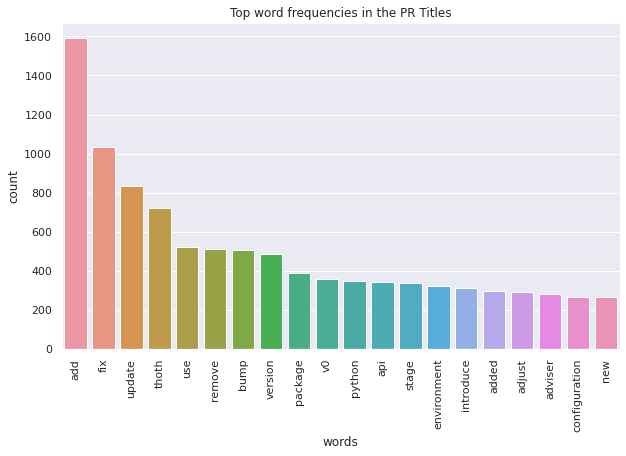

In [101]:
# plot the 20 most common words
sns.barplot(
    x=vc.index[:20],
    y=vc.values[:20],
)
plt.title("Top word frequencies in the PR Titles")
plt.xlabel("words")
plt.xticks(rotation=90)
plt.ylabel("count")
plt.show()

From the above graph, we can see that titles often contain some keywords that can hint towards the type of changes being made in the PR. We will create a feature which is a vector indicating how many times each word appeared in the title. This way, even if a less prominent word is more correlated with time_to_merge, we will be able to capture that relationship.

In [100]:
# add word count columns
for word in tqdm(unique_words):
    pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
        lambda x: x.split().count(word)
    )

In [38]:
# collapse the high dim vector into one column
wordcount_columns = [c for c in pr_df.columns if "wordcount" in c]
pr_df["title_word_counts_vec"] = pr_df[wordcount_columns].apply(
    lambda x: x.tolist(), axis=1
)

# drop the individual wordcount columns
pr_df = pr_df.drop(columns=wordcount_columns)

In [39]:
pr_df.head(2)

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,commits,changed_files,first_review_at,first_approve_at,org,repo,index,time_to_merge,body_size,title_word_counts_vec
6,6,6,668.0,set badges for easy access to content,set badges for easy access to content\r\nSigne...,1,harshad16,2022-02-01 00:00:46,2022-02-01 07:07:54,sesheta,...,['01364aad0093bb29fdb96332568e95f798150e61'],['README.rst'],2022-02-01 07:05:14,2022-02-01 07:05:14,thoth-station,graph-refresh-job,NaN,25628.0,12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
10,10,10,662.0,Enable TLS verification,NaN,0,fridex,2022-01-18 09:50:21,2022-01-19 14:30:30,fridex,...,['5fefb9b3ba56da5c4c4b05351a8e78223abcb023'],['.thoth.yaml'],NaN,NaN,thoth-station,graph-refresh-job,NaN,103209.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Created By**

Is the time taken to merge a PR affected by the author of the PR? E.g. if a code reviewer or someone who has already made several contributions to a repo creates a PR, is it likely to get merged relatively faster?

In [40]:
# Thoth Members list from the repo
thoth_members = [
    "codificat",
    "erikerlandson",
    "fridex",
    "Gkrumbach07",
    "goern",
    "Gregory-Pereira",
    "harshad16",
    "HumairAK",
    "KPostOffice",
    "mayaCostantini",
    "meile18",
    "oindrillac",
    "pacospace",
    "schwesig",
    "sesheta",
    "tumido",
    "xtuchyna",
    "bot",
    "sub-mod",
    "GiorgosKarantonis",
    "CermakM",
    "bjoernh2000",
    "srushtikotak",
    "4n4nd",
    "EldritchJS",
    "sesheta-srcops",
    "Shreyanand",
    "bissenbay",
    "saisankargochhayat",
    "pacospace",
]

In [41]:
# is the pr creator on the approvers or reviewers list
pr_df["is_member"] = pr_df["created_by"].isin(thoth_members)

In [42]:
pr_df.head(2)

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,changed_files,first_review_at,first_approve_at,org,repo,index,time_to_merge,body_size,title_word_counts_vec,is_member
6,6,6,668.0,set badges for easy access to content,set badges for easy access to content\r\nSigne...,1,harshad16,2022-02-01 00:00:46,2022-02-01 07:07:54,sesheta,...,['README.rst'],2022-02-01 07:05:14,2022-02-01 07:05:14,thoth-station,graph-refresh-job,NaN,25628.0,12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True
10,10,10,662.0,Enable TLS verification,NaN,0,fridex,2022-01-18 09:50:21,2022-01-19 14:30:30,fridex,...,['.thoth.yaml'],NaN,NaN,thoth-station,graph-refresh-job,NaN,103209.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True


We also want to derive a feature called `num_prev_merged_prs` captures the number of PRs that the creator created before this PR.

In [43]:
# how many prs did the creator create before this pr
def get_prev_pr_info(creator_pr_df):
    num_prev_merged_prs = (
        creator_pr_df["time_to_merge"].expanding().count().shift(1).fillna(0)
    )
    return num_prev_merged_prs


# need to sort before applying groupby
# because merging is not possible as df index types are different
pr_df = pr_df.sort_values(by="created_at")

num_prev_merged_prs = pr_df.groupby("created_by").apply(get_prev_pr_info)
num_prev_merged_prs = num_prev_merged_prs.reset_index(drop=True).rename("num_prev_prs")

pr_df["num_prev_merged_prs"] = num_prev_merged_prs.values

In [44]:
pr_df.head(2)

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,first_review_at,first_approve_at,org,repo,index,time_to_merge,body_size,title_word_counts_vec,is_member,num_prev_merged_prs
18919,214,214,1.0,removed the janusgraph template due to new loc...,this file is now located at https://raw.github...,2,goern,1970-01-18 14:11:51.836,1970-01-18 14:14:58.324,fridex,...,NaN,NaN,thoth-station,core,NaN,186.488,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.0
18918,213,213,2.0,Download janusgraph template on deployment,Related: #1,0,fridex,1970-01-18 14:14:58.925,1970-01-18 14:14:59.828,fridex,...,NaN,NaN,thoth-station,core,NaN,0.903,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,1.0


**Created At**

This column can give us information on when the PR was created. Using the `created_at` field, we can derive other features like `time_of_day`, `day_of_week`, `day_of_month`, `month_in_year` each of which can be categorical features that can be useful to our analysis.

In [45]:
# get day as categorical variable
pr_df["created_at_day"] = pd.to_datetime(pr_df["created_at"]).apply(lambda x: x.day)

# get month as categorical variable
pr_df["created_at_month"] = pd.to_datetime(pr_df["created_at"]).apply(lambda x: x.month)

# get weekday as categorical variable
pr_df["created_at_weekday"] = pd.to_datetime(pr_df["created_at"]).apply(
    lambda x: x.weekday()
)

# get hour of day as categorical variable
pr_df["created_at_hour"] = pd.to_datetime(pr_df["created_at"]).apply(lambda x: x.hour)

In [46]:
pr_df.head(2)

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,index,time_to_merge,body_size,title_word_counts_vec,is_member,num_prev_merged_prs,created_at_day,created_at_month,created_at_weekday,created_at_hour
18919,214,214,1.0,removed the janusgraph template due to new loc...,this file is now located at https://raw.github...,2,goern,1970-01-18 14:11:51.836,1970-01-18 14:14:58.324,fridex,...,NaN,186.488,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.0,18,1,6,14
18918,213,213,2.0,Download janusgraph template on deployment,Related: #1,0,fridex,1970-01-18 14:14:58.925,1970-01-18 14:14:59.828,fridex,...,NaN,0.903,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,1.0,18,1,6,14


**Commits Number**  
Commits Number gives the number of commits created within the PR. This could be a numerical feature for our model.

In [47]:
pr_df.commits_number.value_counts()

1.0      7835
2.0      1573
3.0       580
4.0       302
5.0       163
6.0       122
7.0        84
8.0        52
9.0        45
10.0       25
12.0       25
11.0       23
0.0        16
14.0       16
13.0       15
15.0        9
17.0        8
19.0        7
16.0        7
18.0        5
24.0        5
20.0        5
26.0        4
21.0        4
27.0        3
29.0        3
32.0        3
35.0        2
23.0        2
25.0        2
22.0        2
94.0        2
63.0        2
40.0        2
37.0        2
36.0        1
28.0        1
30.0        1
77.0        1
55.0        1
76.0        1
56.0        1
31.0        1
100.0       1
48.0        1
101.0       1
67.0        1
Name: commits_number, dtype: int64

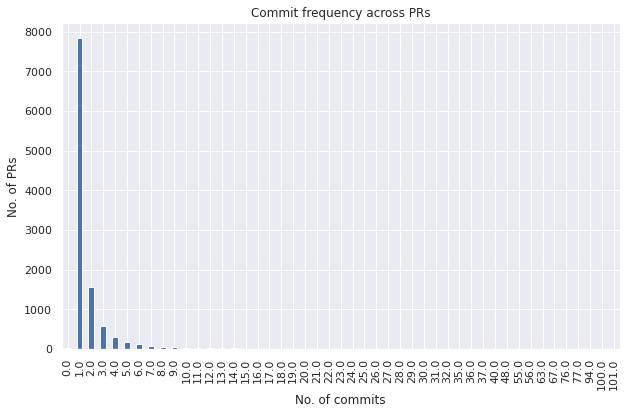

In [48]:
pr_df.commits_number.value_counts().sort_index(ascending=True).plot(kind="bar")
plt.title("Commit frequency across PRs")
plt.xlabel("No. of commits")
plt.ylabel("No. of PRs")
plt.show()

As we see above, in this dataset, there is not much variability in the commits number. Majority of the PRs (77%) have 1 commit, 11% have 2 commits and rest(12%) have more than 2 commits. We can break commits number down into 3 categorical variables, `contains_1_commit`, `contains_2_commits`, `contains_3_or_more_commits`. However, there might be some value in knowing whether a PR had 5 commits vs. 10 commits. So we will treat it as a numerical variable to begin with.

In [49]:
pr_df.head(2)

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,index,time_to_merge,body_size,title_word_counts_vec,is_member,num_prev_merged_prs,created_at_day,created_at_month,created_at_weekday,created_at_hour
18919,214,214,1.0,removed the janusgraph template due to new loc...,this file is now located at https://raw.github...,2,goern,1970-01-18 14:11:51.836,1970-01-18 14:14:58.324,fridex,...,NaN,186.488,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.0,18,1,6,14
18918,213,213,2.0,Download janusgraph template on deployment,Related: #1,0,fridex,1970-01-18 14:14:58.925,1970-01-18 14:14:59.828,fridex,...,NaN,0.903,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,1.0,18,1,6,14


**Changed Files Number**  
Changed files is a numerical variable which captures the number of files that were modified in the PR.

In [50]:
# convert changed_files_number to int
pr_df["changed_files_number"] = pr_df["changed_files_number"].astype("int")

pr_df.changed_files_number.value_counts()

1      5954
2      1932
3       915
4       537
5       289
       ... 
148       1
76        1
85        1
71        1
234       1
Name: changed_files_number, Length: 98, dtype: int64

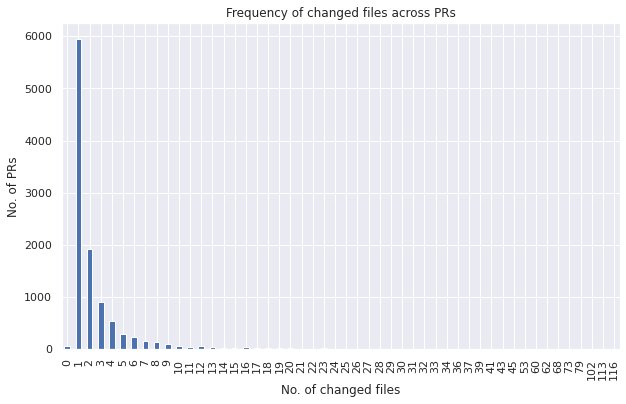

In [51]:
pr_df.changed_files_number.value_counts().iloc[:50].sort_index(ascending=True).plot(
    kind="bar"
)
plt.title("Frequency of changed files across PRs")
plt.xlabel("No. of changed files")
plt.ylabel("No. of PRs")
plt.show()

`changed_files_number` has more variability than the `commits_number`. We can incorporate this as a numerical feature.

**Changed_files**

`changed_files` is a list of the paths and filenames for every file changed by this PR. From `changed_files`, we know, for each PR, which file types were changed which can be encoded as a frequency vector. Also we know which directory the change is made in, so that can be encoded as a categorical variable.

In [52]:
pr_df.changed_files

18919                        ['openshift/janusgraph.yaml']
18918                ['.gitignore', 'openshift/deploy.sh']
18917    ['.gitignore', 'Jenkinsfile', 'README.rst', 'o...
18916                          ['openshift/template.yaml']
18915                          ['openshift/template.yaml']
                               ...                        
7101                             ['docs/source/index.rst']
3458     ['action.yaml', 'actions/ubuntu_config_templat...
3359                          ['content/metrics/index.md']
3358     ['config/documentation.yaml', 'config/support....
3357     ['config/documentation.yaml', 'config/support....
Name: changed_files, Length: 10967, dtype: object

In [53]:
def filetype(filepath):

    # if standard file extension, return file extension
    if pathlib.Path(filepath).suffix:
        return pathlib.Path(filepath).suffix

    else:
        # if single file at the root of repo
        if "/" not in filepath:
            # if a file like README/Dockerfile etc
            if "." not in filepath:
                return filepath
        # if file not at root
        else:
            # get file name
            file = filepath.rsplit("/", 1)[1]
            if "." not in file:
                return file
            elif "." in file:
                return "." + file.rsplit(".", 1)[1]

In [54]:
# get list of all file types that were modified across all thoth station PRs
changed_files = list(pr_df["changed_files"])

In [55]:
changed_files[0]

"['openshift/janusgraph.yaml']"

In [56]:
all_changed_files = [
    filetype(filepath) for pr in changed_files for filepath in ast.literal_eval(pr)
]

In [57]:
count = Counter(all_changed_files)

In [58]:
# save 100 most commonly occuring file extensions across PRs
top_fileextensions_freq = count.most_common(100)

In [59]:
top_fileextensions_freq

[('.py', 14597),
 ('.yaml', 11506),
 ('.md', 2823),
 ('.lock', 1231),
 ('.rst', 986),
 ('.js', 931),
 ('Pipfile', 898),
 ('.png', 758),
 ('.html', 581),
 ('.dat', 570),
 ('.plot', 570),
 ('.json', 553),
 ('.txt', 515),
 ('Dockerfile', 413),
 (None, 360),
 ('.ts', 320),
 ('.sh', 226),
 ('.tsx', 203),
 ('.gif', 181),
 ('log', 160),
 ('hwinfo', 156),
 ('result', 156),
 ('.ipynb', 141),
 ('.yml', 126),
 ('.in', 124),
 ('.toml', 112),
 ('OWNERS', 111),
 ('.css', 99),
 ('.ini', 87),
 ('assemble', 82),
 ('.feature', 72),
 ('CODEOWNERS', 65),
 ('.dia', 63),
 ('.cache', 57),
 ('.template', 53),
 ('.patch', 48),
 ('Jenkinsfile', 38),
 ('.svg', 35),
 ('.rdf', 30),
 ('.jpg', 30),
 ('.tmpl', 21),
 ('OWNERS_ALIASES', 20),
 ('.zip', 19),
 ('LICENSE', 18),
 ('.typed', 18),
 ('Makefile', 17),
 ('.pdf', 16),
 ('.graphml', 15),
 ('run', 14),
 ('vars', 12),
 ('.go', 12),
 ('.cfg', 12),
 ('.vue', 12),
 ('.cpp', 11),
 ('.h', 11),
 ('.retry', 10),
 ('vault', 9),
 ('add-ist', 9),
 ('.gitignore', 9),
 ('.hpp',

In [60]:
top_fileextensions = [ext[0] for ext in top_fileextensions_freq]

In [61]:
top_fileextensions

['.py',
 '.yaml',
 '.md',
 '.lock',
 '.rst',
 '.js',
 'Pipfile',
 '.png',
 '.html',
 '.dat',
 '.plot',
 '.json',
 '.txt',
 'Dockerfile',
 None,
 '.ts',
 '.sh',
 '.tsx',
 '.gif',
 'log',
 'hwinfo',
 'result',
 '.ipynb',
 '.yml',
 '.in',
 '.toml',
 'OWNERS',
 '.css',
 '.ini',
 'assemble',
 '.feature',
 'CODEOWNERS',
 '.dia',
 '.cache',
 '.template',
 '.patch',
 'Jenkinsfile',
 '.svg',
 '.rdf',
 '.jpg',
 '.tmpl',
 'OWNERS_ALIASES',
 '.zip',
 'LICENSE',
 '.typed',
 'Makefile',
 '.pdf',
 '.graphml',
 'run',
 'vars',
 '.go',
 '.cfg',
 '.vue',
 '.cpp',
 '.h',
 '.retry',
 'vault',
 'add-ist',
 '.gitignore',
 '.hpp',
 '.markdown',
 'Pipfile_test1',
 'pylintrc',
 '.so',
 'bandit',
 '.scss',
 'pre-commit',
 'environment',
 '.xml',
 'aggregated',
 'cloc',
 'Containerfile',
 'pre-push',
 '.pyc',
 'Pipfile_provenance2',
 'skopeo',
 'README',
 'setup',
 'VERSION',
 '.xcf',
 '.inv',
 'Pipfile_provenance1',
 'Pipfile_test2',
 'JenkinsfileTrigger',
 'thoth-storages',
 '.pyi',
 '.csv',
 'specification',


In [62]:
def file_type_freq(list_of_filepaths):
    """
    For a given PR's list of changed files,
    return a changed files frequency vector
    ( a vector which holds the frequency of
    changed files of the type  for every
    file type in top_fileextensions )
    """

    file_extensions = [filetype(f) for f in list_of_filepaths]
    ext_dict = {key: 0 for key in top_fileextensions}
    for f in file_extensions:
        if f in ext_dict:
            ext_dict[f] += 1

    return list(ext_dict.values())

In [63]:
pr_df["changed_file_type_vec"] = pr_df["changed_files"].apply(
    lambda x: file_type_freq(x)
)

In [64]:
pr_df.head(2)

,Unnamed: 0.1,Unnamed: 0,id,title,body,size,created_by,created_at,closed_at,closed_by,...,time_to_merge,body_size,title_word_counts_vec,is_member,num_prev_merged_prs,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_file_type_vec
18919,214,214,1.0,removed the janusgraph template due to new loc...,this file is now located at https://raw.github...,2,goern,1970-01-18 14:11:51.836,1970-01-18 14:14:58.324,fridex,...,186.488,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.0,18,1,6,14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
18918,213,213,2.0,Download janusgraph template on deployment,Related: #1,0,fridex,1970-01-18 14:14:58.925,1970-01-18 14:14:59.828,fridex,...,0.903,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,1.0,18,1,6,14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ..."


## Infer dataframe columns as Features

In [65]:
# subset DataFrame to use as features
feature_df = pr_df[
    [
        "time_to_merge",
        "changed_files_number",
        "body_size",
        "size",
        "title_word_counts_vec",
        "is_member",
        "num_prev_merged_prs",
        "created_at_day",
        "created_at_month",
        "created_at_weekday",
        "created_at_hour",
        "commits_number",
        "changed_file_type_vec",
    ]
]

### Add PR TTM Class Column 

Lets split up the time to merge values into 10 discrete bins (as discussed above) to use as our prediction classes.

The roughly equal sized buckets that we derived earlier are class 0 is "merged within 1 minute", class 1 is "merged within 2 mins", class 2 is "merged within 5 minutes", class 3 is "merged within 10 mins", class 4 is "merged within 30 mins", class 5 is "merged within 2 hrs", class 6 is "merged within 8 hrs", class 7 is "merged within 17 hrs", class 8 is "merged within 4 days", class 9 is "merged in greater than 4 days".

In [66]:
def get_ttm_class(ttm):
    """
    Assign a ttm "class" / "category" / "bin" to the input numerical ttm value
    E.g. if the time to merge was 1 hours, this function will return
    class "5" which represents "merged in 0.5-2 hours"
    """
    if ttm < 0.0166667:
        return 0
    elif ttm < 0.0333333:
        return 1
    elif ttm < 0.0833333:
        return 2
    elif ttm < 0.166667:
        return 3
    elif ttm < 0.5:
        return 4
    elif ttm < 2:
        return 5
    elif ttm < 8:
        return 6
    elif ttm < 17:
        return 7
    elif ttm < 96:
        return 8
    else:
        return 9


feature_df["ttm_class"] = (feature_df["time_to_merge"] / 3600).apply(get_ttm_class)
feature_df.head()

/tmp/ipykernel_511/2041586318.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["ttm_class"] = (feature_df["time_to_merge"] / 3600).apply(get_ttm_class)


,time_to_merge,changed_files_number,body_size,size,title_word_counts_vec,is_member,num_prev_merged_prs,created_at_day,created_at_month,created_at_weekday,created_at_hour,commits_number,changed_file_type_vec,ttm_class
18919,186.488,1,7,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.0,18,1,6,14,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",2
18918,0.903,2,2,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,1.0,18,1,6,14,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...",0
18917,1021.932,12,2,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,0.0,18,1,6,14,14.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11,...",4
18916,NaN,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,1.0,18,1,6,14,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9
18915,NaN,1,35,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,2.0,18,1,6,14,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9


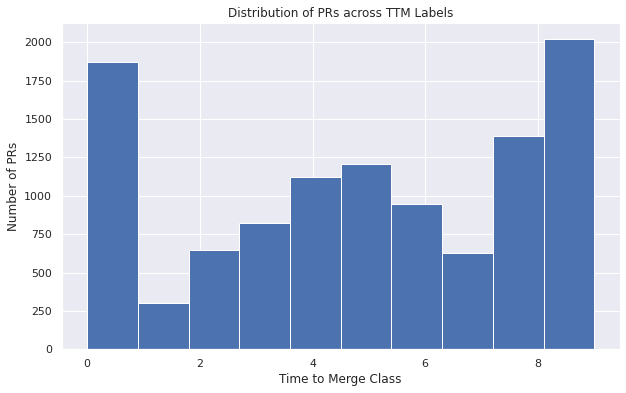

In [67]:
# visualize data points distribution across classes
feature_df["ttm_class"].hist()
plt.title("Distribution of PRs across TTM Labels")
plt.xlabel("Time to Merge Class")
plt.ylabel("Number of PRs")
plt.show()

From the above graph, we can see that data is fairly uniformly distributed across all classes. At the same time, the class definitions are also easily interpretable by human experts. So this seems like a good setup for our classification task.

## Evaluating Feature Importances

### Categorical Features

First, lets try to determine what categorical featuers are powerful influencers for time to merge of a PR

In [68]:
# feature selection helper function
def select_features(x, y, func):
    fs = SelectKBest(score_func=func, k="all")
    fs.fit(x, y)
    x_fs = fs.transform(x)
    return x_fs, fs


selected_features = []

In [69]:
cat_df = feature_df[
    [
        "size",
        "is_member",
        "created_at_day",
        "created_at_month",
        "created_at_weekday",
        "created_at_hour",
        "ttm_class",
    ]
]

cat_df.head()

,size,is_member,created_at_day,created_at_month,created_at_weekday,created_at_hour,ttm_class
18919,2,True,18,1,6,14,2
18918,0,True,18,1,6,14,0
18917,5,True,18,1,6,14,4
18916,0,True,18,1,6,14,9
18915,1,True,18,1,6,14,9


In [70]:
# split into input (x) and output (y) variables
X_inp = cat_df.drop(columns=["ttm_class"])
y = cat_df["ttm_class"]

In [71]:
# rank using mutual_info_classif
X_fs, fs = select_features(X_inp, y, mutual_info_classif)

In [72]:
for i in range(len(fs.scores_)):
    print("Feature %s: %f" % (X_inp.columns[i], fs.scores_[i]))

Feature size: 0.023386
Feature is_member: 0.003967
Feature created_at_day: 0.184591
Feature created_at_month: 0.160910
Feature created_at_weekday: 0.087032
Feature created_at_hour: 0.069809


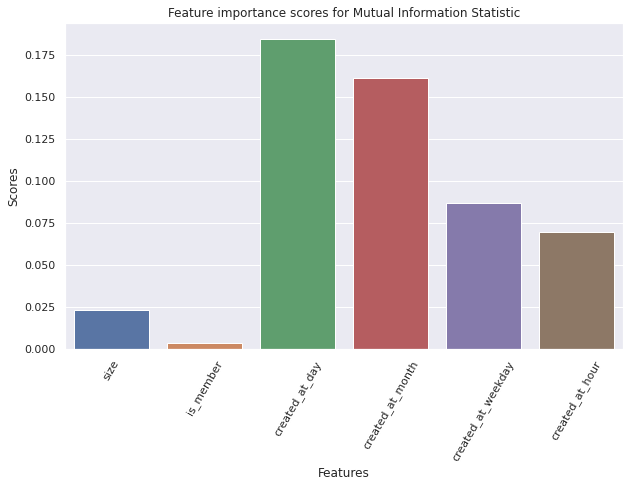

In [73]:
# visualize scores of all features
sns.barplot(x=X_inp.columns, y=fs.scores_)
plt.title("Feature importance scores for Mutual Information Statistic")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

In [74]:
# Lets get a list of the top 5 feature indices based on Mutual Info Stat feature scores
top_mis = fs.scores_.argsort()[-5:][::-1]

In [75]:
# rank using chi_sq
X_fs, fs = select_features(X_inp, y, chi2)

In [76]:
for i in range(len(fs.scores_)):
    print("Feature %s: %f" % (X_inp.columns[i], fs.scores_[i]))

Feature size: 701.291071
Feature is_member: 1.643581
Feature created_at_day: 696.369098
Feature created_at_month: 5169.685398
Feature created_at_weekday: 1016.574393
Feature created_at_hour: 866.139793


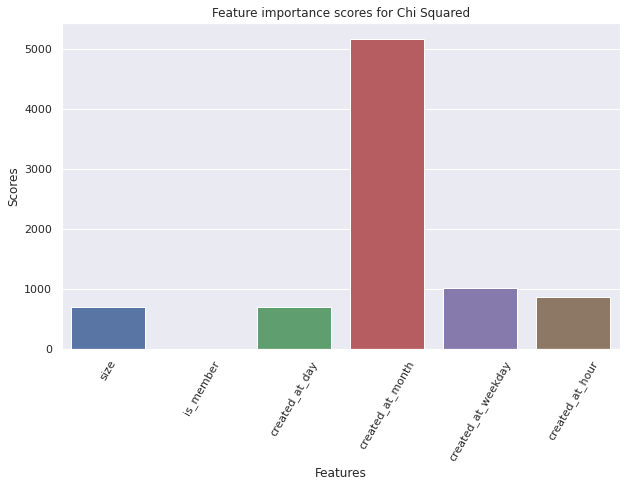

In [77]:
# visualize scores of all features
sns.barplot(x=X_inp.columns, y=fs.scores_)
plt.title("Feature importance scores for Chi Squared")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

In [78]:
# Lets get a list of the top 5 feature indices based on Chi Sq feature scores
top_chi2 = fs.scores_.argsort()[-5:][::-1]

Let's get a Union of the top 5 features derived from features based on both scores of both Mutual Info Statistic and Chi Squared

In [79]:
union = set(top_mis).union(set(top_chi2))
print(len(union))
union

5


{0, 2, 3, 4, 5}

We now have the top 12 features based on their feature importance scores. We can eliminate the remaining 7 features from the categorical features which have low feature importance scores for both  Mutual Info Statistic and Chi Squared 

In [80]:
cat_df.head()

,size,is_member,created_at_day,created_at_month,created_at_weekday,created_at_hour,ttm_class
18919,2,True,18,1,6,14,2
18918,0,True,18,1,6,14,0
18917,5,True,18,1,6,14,4
18916,0,True,18,1,6,14,9
18915,1,True,18,1,6,14,9


In [81]:
# update list of features to keep for training
selected_features += [
    "size",
    "created_at_day",
    "created_at_month",
    "created_at_weekday",
    "created_at_hour",
]

### Numerical Features

Now, lets try to determine what numerical featuers are powerful influencers for time to merge of a PR

In [82]:
numerical_df = feature_df[
    [
        "changed_files_number",
        "body_size",
        "num_prev_merged_prs",
        "commits_number",
        "ttm_class",
    ]
]

numerical_df.head()

,changed_files_number,body_size,num_prev_merged_prs,commits_number,ttm_class
18919,1,7,0.0,1.0,2
18918,2,2,1.0,1.0,0
18917,12,2,0.0,14.0,4
18916,1,0,1.0,1.0,9
18915,1,35,2.0,1.0,9


In [83]:
# split into input features and target
X_inp = numerical_df.drop(columns=["ttm_class"])
y = numerical_df["ttm_class"]

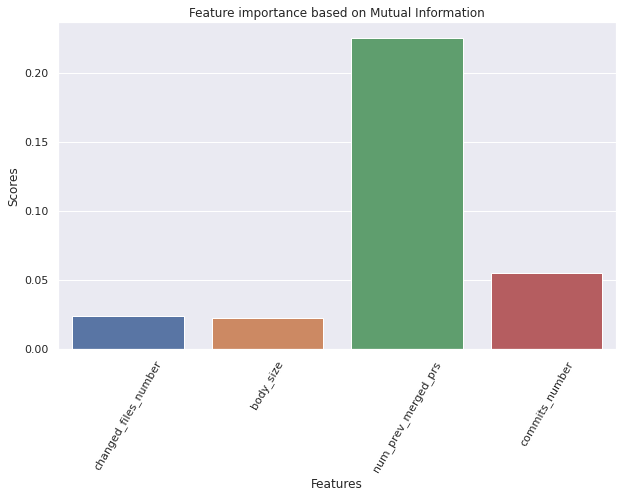

In [84]:
# create k best feature selector object based on mutual information
numerical_feats_mi, k_best_selector_mi = select_features(
    X_inp,
    y,
    partial(
        mutual_info_classif,
        discrete_features=False,
        random_state=42,
        n_neighbors=3,
    ),
)

# visualize the MI scores of all features
sns.barplot(x=X_inp.columns, y=k_best_selector_mi.scores_)
plt.title("Feature importance based on Mutual Information")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

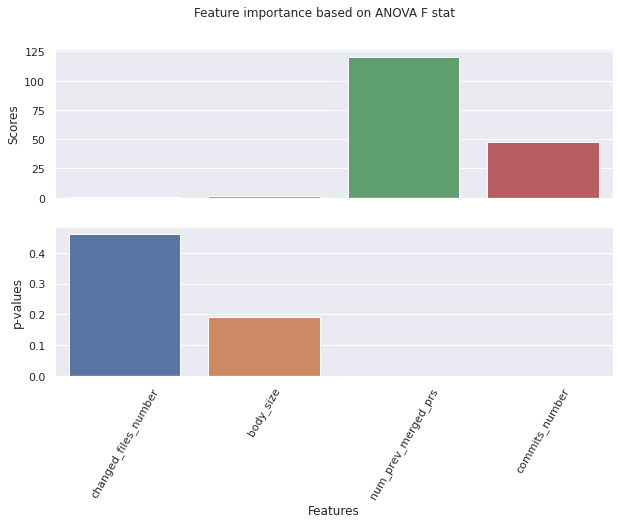

In [85]:
# create k best feature selector object based on anova f statistic
numerical_feats_f, k_best_selector_f = select_features(
    X_inp,
    y,
    f_classif,
)

# visualize the f stat scores and pvalues of all features
fig, axes = plt.subplots(2, 1, sharex=True)
fig.suptitle("Feature importance based on ANOVA F stat")
sns.barplot(x=X_inp.columns, y=k_best_selector_f.scores_, ax=axes[0])
sns.barplot(x=X_inp.columns, y=k_best_selector_f.pvalues_, ax=axes[1])
plt.xticks(rotation=60)
plt.xlabel("Features")
axes[0].set_ylabel("Scores")
axes[1].set_ylabel("p-values")
plt.show()

From the above cells, we can see that different features are scored differently based on mutual information criterion and ANOVA F statistic. Since there are only 4 of these features, we will keep all of them in our features dataframe.

In [86]:
# update list of features to keep for training
selected_features += [
    "changed_files_number",
    "body_size",
    "num_prev_merged_prs",
    "commits_number",
]

### Count Vector Type Features

Finally, lets determine the most important features from the count vector type columns.

In [87]:
# explode the list column so that there is 1 column representing frequency of each file type
filetype_df = pd.DataFrame(feature_df.changed_file_type_vec.to_list())
filetype_df.index = feature_df.index
filetype_df.columns = [f"filetype_{f}" for f in top_fileextensions]

In [88]:
filetype_df

,filetype_.py,filetype_.yaml,filetype_.md,filetype_.lock,filetype_.rst,filetype_.js,filetype_Pipfile,filetype_.png,filetype_.html,filetype_.dat,...,filetype_Pipfile_project0,filetype_.mako,filetype_.sql,filetype_.train,filetype_.bin,filetype_.solver-fedora-31-py37,filetype_.solver-fedora-32-py38,filetype_.solver-rhel-8-py36,filetype_.solver-rhel-8-py38,filetype_Pipfile_thoth
18919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18918,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
# compute correlation with ttm
corr = filetype_df.corrwith(feature_df["ttm_class"])
corr.sort_values(ascending=False)

filetype_None                     -0.007134
filetype_.py                            NaN
filetype_.yaml                          NaN
filetype_.md                            NaN
filetype_.lock                          NaN
                                     ...   
filetype_.solver-fedora-31-py37         NaN
filetype_.solver-fedora-32-py38         NaN
filetype_.solver-rhel-8-py36            NaN
filetype_.solver-rhel-8-py38            NaN
filetype_Pipfile_thoth                  NaN
Length: 100, dtype: float64

In [90]:
corr[corr.abs() > 0.01]

Series([], dtype: float64)

We see above that there is no correlation between ttm_class and filetype

In [91]:
# explode the list column so that there is 1 column representing frequency of each word
title_wordcount_df = pd.DataFrame(feature_df.title_word_counts_vec.to_list())

title_wordcount_df.index = feature_df.index
title_wordcount_df.columns = [f"title_wordcount_{w}" for w in unique_words]

In [92]:
# compute correlation with ttm
corr = title_wordcount_df.corrwith(feature_df["ttm_class"])
corr = corr.dropna()
corr.sort_values(ascending=False)

title_wordcount_wip          0.138246
title_wordcount_python       0.081006
title_wordcount_introduce    0.061996
title_wordcount_pyproject    0.061008
title_wordcount_add          0.058990
                               ...   
title_wordcount_reporter    -0.086708
title_wordcount_prod        -0.101685
title_wordcount_v0          -0.195684
title_wordcount_stage       -0.216384
title_wordcount_bump        -0.237768
Length: 4101, dtype: float64

In [93]:
corr[corr.abs() > 0.045]

title_wordcount_add             0.058990
title_wordcount_adviser        -0.060380
title_wordcount_amun           -0.056737
title_wordcount_api            -0.085951
title_wordcount_bump           -0.237768
title_wordcount_certs          -0.060026
title_wordcount_cluster        -0.047036
title_wordcount_deployment     -0.050216
title_wordcount_environment    -0.079035
title_wordcount_exporter       -0.086338
title_wordcount_fix            -0.052976
title_wordcount_functions       0.045857
title_wordcount_graph          -0.057270
title_wordcount_implement       0.048837
title_wordcount_increase       -0.074003
title_wordcount_ingestion      -0.046845
title_wordcount_integration    -0.047605
title_wordcount_introduce       0.061996
title_wordcount_investigator   -0.069694
title_wordcount_kustomize      -0.048891
title_wordcount_management     -0.065311
title_wordcount_manifest       -0.047074
title_wordcount_middletier     -0.047666
title_wordcount_moc            -0.047437
title_wordcount_

In [94]:
# update list of features to keep for training
# take everything that has more than 0.045 correlation magnitude
keep_cols = corr[corr.abs() > 0.045].index.tolist()
selected_features += keep_cols

title_wordcount_df = title_wordcount_df[keep_cols]

Using various feature importance scores such as chi-squared, mutual information statistic, correlation values, we have selected the most relevant features amongst all of our features. 

In [95]:
selected_features

['size',
 'created_at_day',
 'created_at_month',
 'created_at_weekday',
 'created_at_hour',
 'changed_files_number',
 'body_size',
 'num_prev_merged_prs',
 'commits_number',
 'title_wordcount_add',
 'title_wordcount_adviser',
 'title_wordcount_amun',
 'title_wordcount_api',
 'title_wordcount_bump',
 'title_wordcount_certs',
 'title_wordcount_cluster',
 'title_wordcount_deployment',
 'title_wordcount_environment',
 'title_wordcount_exporter',
 'title_wordcount_fix',
 'title_wordcount_functions',
 'title_wordcount_graph',
 'title_wordcount_implement',
 'title_wordcount_increase',
 'title_wordcount_ingestion',
 'title_wordcount_integration',
 'title_wordcount_introduce',
 'title_wordcount_investigator',
 'title_wordcount_kustomize',
 'title_wordcount_management',
 'title_wordcount_manifest',
 'title_wordcount_middletier',
 'title_wordcount_moc',
 'title_wordcount_namespace',
 'title_wordcount_notebook',
 'title_wordcount_ocp4',
 'title_wordcount_parallelism',
 'title_wordcount_party',
 't

## Save Feature Engineered Dataset

In [96]:
# join all types of features
ttm_dataset = pd.concat(
    [feature_df, filetype_df, title_wordcount_df], axis=1, ignore_index=False
)

# keep only the selected features and the prediction label
ttm_dataset = ttm_dataset[selected_features + ["ttm_class", "time_to_merge"]]

ttm_dataset.head()

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,num_prev_merged_prs,commits_number,title_wordcount_add,...,title_wordcount_stage,title_wordcount_toml,title_wordcount_upgrade,title_wordcount_v0,title_wordcount_v1,title_wordcount_v2021,title_wordcount_version,title_wordcount_wip,ttm_class,time_to_merge
18919,2,18,1,6,14,1,7,0.0,1.0,0,...,0,0,0,0,0,0,0,0,2,186.488
18918,0,18,1,6,14,2,2,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0.903
18917,5,18,1,6,14,12,2,0.0,14.0,0,...,0,0,0,0,0,0,0,0,4,1021.932
18916,0,18,1,6,14,1,0,1.0,1.0,0,...,0,0,0,0,0,0,0,0,9,NaN
18915,1,18,1,6,14,1,35,2.0,1.0,0,...,0,0,0,0,0,0,0,0,9,NaN


In [97]:
ttm_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10967 entries, 18919 to 3357
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   size                          10967 non-null  int64  
 1   created_at_day                10967 non-null  int64  
 2   created_at_month              10967 non-null  int64  
 3   created_at_weekday            10967 non-null  int64  
 4   created_at_hour               10967 non-null  int64  
 5   changed_files_number          10967 non-null  int64  
 6   body_size                     10967 non-null  int64  
 7   num_prev_merged_prs           10967 non-null  float64
 8   commits_number                10967 non-null  float64
 9   title_wordcount_add           10967 non-null  int64  
 10  title_wordcount_adviser       10967 non-null  int64  
 11  title_wordcount_amun          10967 non-null  int64  
 12  title_wordcount_api           10967 non-null  int64  
 13

In [98]:
ttm_dataset

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,num_prev_merged_prs,commits_number,title_wordcount_add,...,title_wordcount_stage,title_wordcount_toml,title_wordcount_upgrade,title_wordcount_v0,title_wordcount_v1,title_wordcount_v2021,title_wordcount_version,title_wordcount_wip,ttm_class,time_to_merge
18919,2,18,1,6,14,1,7,0.0,1.0,0,...,0,0,0,0,0,0,0,0,2,186.488
18918,0,18,1,6,14,2,2,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0.903
18917,5,18,1,6,14,12,2,0.0,14.0,0,...,0,0,0,0,0,0,0,0,4,1021.932
18916,0,18,1,6,14,1,0,1.0,1.0,0,...,0,0,0,0,0,0,0,0,9,NaN
18915,1,18,1,6,14,1,35,2.0,1.0,0,...,0,0,0,0,0,0,0,0,9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7101,1,24,5,1,17,1,28,232.0,1.0,0,...,0,0,0,0,0,0,0,0,9,NaN
3458,0,24,5,1,20,2,28,232.0,1.0,0,...,0,0,0,0,0,0,0,0,1,109.000
3359,0,25,5,2,15,1,12,233.0,1.0,1,...,0,0,0,0,0,0,0,0,9,NaN
3358,2,25,5,2,19,11,0,234.0,2.0,0,...,0,0,0,0,0,0,0,0,9,NaN


## Save results to Ceph or locally

Using the helper function to save the data frame in a parquet format on the Ceph bucket if we are running in automation, and locally if not.

In [99]:
## Sanity check to see if the dataset is the same

if REMOTE:
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    try:
        cc.upload_to_ceph(
            ttm_dataset,
            s3_path,
            "thoth-station/ttm_train_test_dataset.parquet",
        )
    except ValueError as ve:
        print(ve)
        print("Files already uploaded to S3")

else:
    save_to_disk(
        ttm_dataset,
        OUTPUT_DATA_PATH,
        "ttm_dataset.parquet",
    )

# Conclusion

This notebook walked through how to access and engineer features from the the relevant PR data for repos on the Thoth Station Org. We also outlined what is contained in each record and provided a quick demonstration of how to convert the mixed data types into numerical values for statistical analysis and eventually machine learning. 

We have also engineered some possible features which can be used to predict time to merge of a PR. As next steps, we will train a classifier to predict time to merge of a PR using the features.